In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import statistics
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from scipy.optimize import fmin_l_bfgs_b

# MNSIT Model Training

In [2]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset)//5*3))

In [5]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [6]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.dropout = nn.Dropout(p=dropout_prob)
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)       
        x = self.dropout(x)
        output = self.out(x)
        # m = nn.Softmax(dim=1)   # Softmax
        # output = m(output);     # Softmax
        return output, x


In [7]:
model = CNN(0.25)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [9]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders, ratio = 1):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        cnt=0
        for i, (images, labels) in enumerate(loaders['train']):
            # cnt+=1
            # if cnt==total_step*ratio:
            #     break
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)[0]             
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass
train(num_epochs, model, loaders)

Epoch [1/5], Step [100/600], Loss: 0.1560
Epoch [1/5], Step [200/600], Loss: 0.1815
Epoch [1/5], Step [300/600], Loss: 0.1027
Epoch [1/5], Step [400/600], Loss: 0.2020
Epoch [1/5], Step [500/600], Loss: 0.2595
Epoch [1/5], Step [600/600], Loss: 0.0951
Epoch [2/5], Step [100/600], Loss: 0.0731
Epoch [2/5], Step [200/600], Loss: 0.1383
Epoch [2/5], Step [300/600], Loss: 0.1952
Epoch [2/5], Step [400/600], Loss: 0.1109
Epoch [2/5], Step [500/600], Loss: 0.1724
Epoch [2/5], Step [600/600], Loss: 0.1158
Epoch [3/5], Step [100/600], Loss: 0.2145
Epoch [3/5], Step [200/600], Loss: 0.0595
Epoch [3/5], Step [300/600], Loss: 0.1722
Epoch [3/5], Step [400/600], Loss: 0.1156
Epoch [3/5], Step [500/600], Loss: 0.0536
Epoch [3/5], Step [600/600], Loss: 0.0569
Epoch [4/5], Step [100/600], Loss: 0.0733
Epoch [4/5], Step [200/600], Loss: 0.1550
Epoch [4/5], Step [300/600], Loss: 0.0144
Epoch [4/5], Step [400/600], Loss: 0.1811
Epoch [4/5], Step [500/600], Loss: 0.0646
Epoch [4/5], Step [600/600], Loss:

In [10]:
def test():
    # model.eval()  ## Dropout Off
    model.train() ## Dropout On
    with torch.no_grad():
        s = 0
        p = 0
        for images, labels in loaders['test']:
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            s += (pred_y == labels).sum().item();
            p += float(labels.size(0))
            pass
        accuracy = s / p;
    print('Test Accuracy : %.3f' % accuracy)
    pass
test()

Test Accuracy : 0.970


# Uncertanity Estimation

In [11]:
def uncertainty(model,data,labels,times=50):
  l = []
  pred = []
  img_ind = []
  f = 0
  ff = 0
  acc = torch.zeros(1, 10)
  t = torch.ones(1, 10)
  p = torch.ones(1, 10)
  t = t * times
  data=data.reshape(1,1,28,28)
  labels = int(labels.item())
  for i in range(times):
    model.train()
    output,layer=model(data)
    pred_y = torch.max(output, 1)[1].data.numpy().squeeze()
    pred.append(pred_y)
    l.append(output)
    
    m = nn.Softmax(dim=1);
    l[i] = m(l[i])
    acc = acc + l[i]
    if pred_y!=labels:
        f = 1
        ff = pred_y
  
  acc /= times
  p[0, labels] = 0
  acc = p - acc
  acc[0, labels] = (acc[0, labels])*(-1)

  return l, pred, acc, f, ff

In [12]:
def normalize(ans):
    for i in range(len(ans)):
        with torch.no_grad(): 
            ans[i] = torch.Tensor.numpy(ans[i])
    ans = np.asarray(ans)
    ans = np.ones((1,10), float) - np.var(ans,axis=0)
    ans *= 100;
    return ans

In [13]:
ans = []
imgs = []
pred = []
cnt = 0
total = 250
accuracy = []
ind = []
act = []
indf = []

actual = torch.zeros(1, total)
for images, labels in loaders['test']:
    imgs.append(images)
    if cnt >= 250: 
        break
    res, pred_y, acc, f, ff = uncertainty(model, images, labels)
    res = normalize(res)
    pred.append(pred_y)
    ans.append(res)
    accuracy.append(acc)
    actual[0, cnt] = labels
    if f:
        ind.append(cnt)
        indf.append(ff)
        act.append(int(labels))
    cnt += 1
    


ans = torch.tensor(ans, dtype=torch.float)

<ipython-input-13-5876b863e5af>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  ans = torch.tensor(ans, dtype=torch.float)


In [14]:
def correlation(ans, accuracy):
    corr = torch.zeros(1, ans.size()[0])
    for i in range(ans.size()[0]): 
        tensor1 = accuracy[i]
        tensor2 = ans[i]

        mean1 = torch.mean(tensor1)
        mean2 = torch.mean(tensor2)

        tensor1 = tensor1 - mean1
        tensor2 = tensor2 - mean2

        res = torch.sum(torch.mul(tensor1, tensor2)) / (torch.sqrt(torch.sum(torch.mul(tensor1, tensor1))) * torch.sqrt(torch.sum(torch.mul(tensor2, tensor2))))
        if (torch.sqrt(torch.sum(torch.mul(tensor1, tensor1))) * torch.sqrt(torch.sum(torch.mul(tensor2, tensor2)))) == 0: 
            corr[0,i] = 1
        else:
            corr[0, i] = res
    return corr

In [15]:
corr = correlation(ans, accuracy)

In [16]:
def plot(x, y):
    figure = plt.figure(figsize=(20, 5))

    figure.add_subplot(1, 3, 1)
    plt.scatter(x, y)

    plt.subplot(1, 3, 2)
    sns.set(style="whitegrid")
    sns.stripplot(x=x, y=y, jitter=0.2)

    plt.subplot(1, 3, 3)
    sns.kdeplot(x,y, shade = True, cbar=True)

    plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


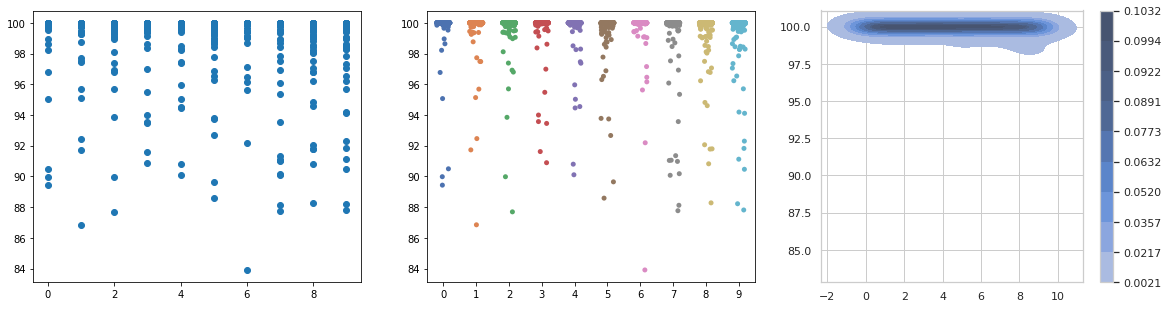

In [17]:
x = []
y = []

for i in range(250):
    for j in range(10):
        x.append(j)
        y.append(float(ans[i][0, j]))

plot(x, y)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


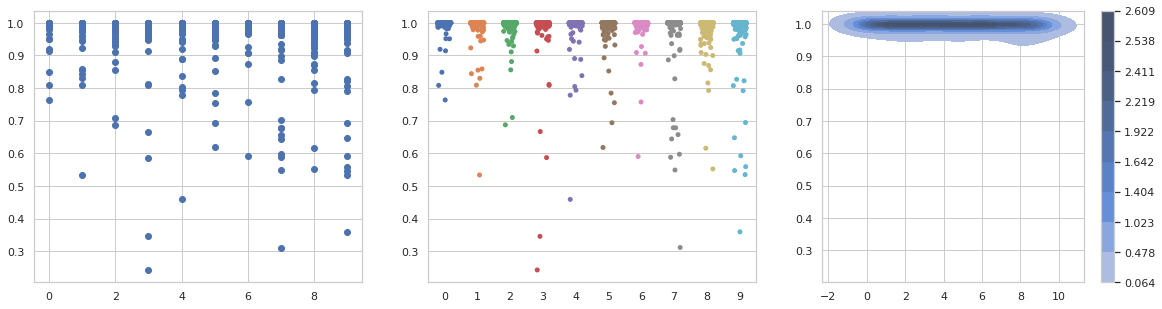

In [18]:
x1 = []
y1 = []

for i in range(250):
    for j in range(10):
        x1.append(j)
        y1.append(float(accuracy[i][0, j]))

plot(x1, y1)

In [19]:
def relation(j):
    a = []
    b = []

    for i in range(250):
        a.append(float(accuracy[i][0, j]))
        b.append(float(ans[i][0, j]))
    plot(a, b);
    return a, b

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


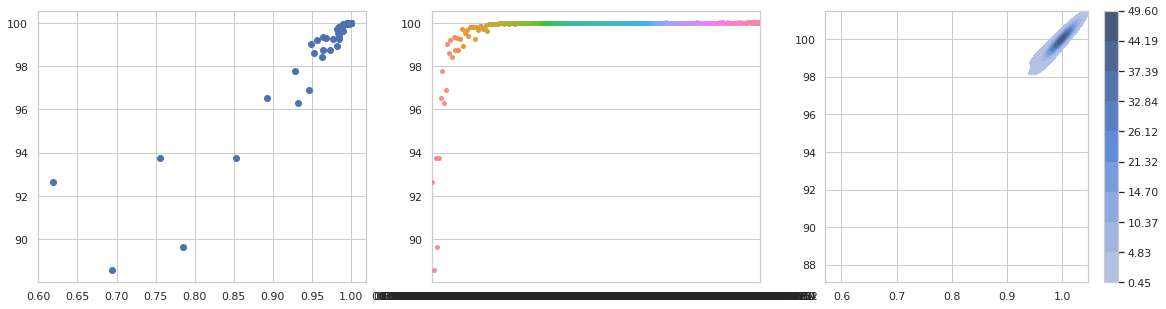

In [20]:
a, b = relation(5)

In [21]:
def plot_image(unc,acc,a,b):
    images_index=[]
    for i in range(len(a)):
        if a[i]<=unc and b[i]<=acc:
            images_index.append(i)
    return images_index

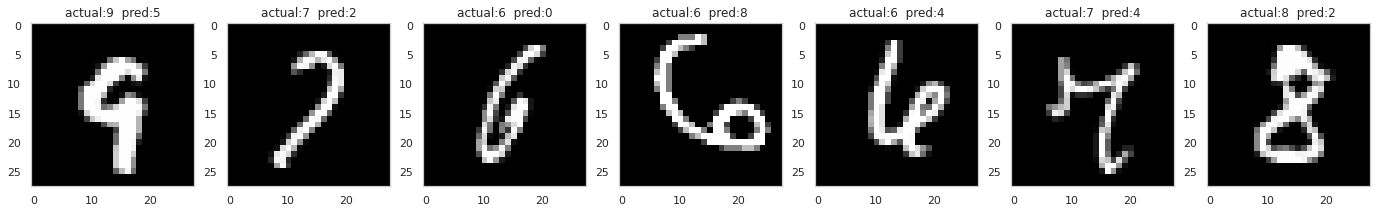

In [22]:
item = 7
fig, axs = plt.subplots(1, item, figsize=(24,24))
for i in range(item):
    axs[i].imshow(imgs[ind[i]].reshape(28,28).squeeze(), cmap="gray")
    axs[i].set_title(f"actual:{act[i]}  pred:{indf[i]}")
    axs[i].grid(False)
plt.show()

# Adversarial Attack Implementation



In [23]:
def fgsm(image, model, epsilon):
    # Set the model to evaluation mode
    model.eval()

    # Disable gradients
    image.requires_grad = True

    # Forward pass
    output, x = model(image)
    
    # Calculate the loss
    loss = F.nll_loss(output, torch.tensor([0]))

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Generate the adversarial example
    sign_data_grad = image.grad.sign()
    perturbed_image = image + epsilon * sign_data_grad

    # Clip the image to be within 0 and 1
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [24]:
img = []
lab = []
for images, labels in loaders['test']:
  img.append(images)
  lab.append(labels)

In [25]:
def fgsm_attack(epsilon, index):
    
    # Generate the adversarial example
    perturbed_image = fgsm(img[index], model, epsilon).squeeze(0)
    perturbed_image = perturbed_image.unsqueeze(0)

    return perturbed_image

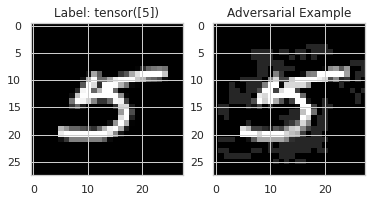

In [26]:
# Get a random image from the test dataset
index = random.randint(0, len(test_dataset) - 1)
epsilon = 0.15

perturbed_image = fgsm_attack(epsilon, index)
# Plot the original and perturbed images
fig, axs = plt.subplots(1, 2)
with torch.no_grad(): 
    axs[0].imshow(img[index].squeeze(), cmap='gray')
    axs[0].set_title(f"Label: {lab[index]}")
    axs[1].imshow(perturbed_image.squeeze(), cmap='gray')
    axs[1].set_title("Adversarial Example")
plt.show()

In [27]:
with torch.no_grad():
    test_output, last_layer = model(img[index])
    perturb_output, last_layer = model(perturbed_image)

print(f"Test :- {test_output} \nPerturb :- {perturb_output}")

Test :- tensor([[-12.9338, -12.3719,  -8.5549,   2.2139,  -8.7200,  10.1662,  -9.5347,
          -8.0836,  -1.7515,  -4.5709]]) 
Perturb :- tensor([[-22.4645,  -9.0536, -10.4901,   2.8618,  -5.5764,  12.3790, -15.1419,
          -7.4232,  -1.6989,  -3.1394]])


In [28]:
cer_y = []
cer_per = []
pred = []
count = 0
itr = 200

for i in range(itr):
     a, x = model(img[i])
     b, x = model(fgsm_attack(epsilon, i))
     a = torch.max(a, 1)[1].data.squeeze()
     b = torch.max(b, 1)[1].data.squeeze()
     if a != b:
         count += 1
     unc_a,_,_,_,_ = uncertainty(model,img[i],lab[i])
     unc_b,_,_,_,_ = uncertainty(model,fgsm_attack(0.15,i),lab[i])
     unc_a = normalize(unc_a)
     unc_b = normalize(unc_b)
     cer_y.append(unc_a[0, int(a)])
     cer_per.append(unc_b[0, int(a)])
     pred.append(a)
print(count*100 / itr)

11.5


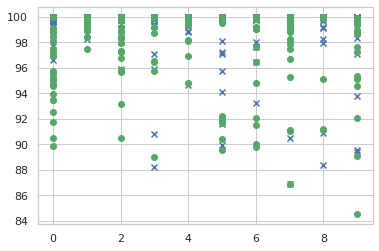

In [29]:
plt.scatter(pred, cer_y, c='b', marker='x')
plt.scatter(pred, cer_per, c='g', marker='o')

In [30]:
def lbfgs_attack(model, loss_fn, x, y, eps=0.1, max_iter=20):
    # Set the model in evaluation mode
    model.eval()
    
    # Create a copy of the input tensor as a starting point for the attack
    x_adv = x.detach().clone().requires_grad_(True)

    # Define the L-BFGS optimizer
    optimizer = optim.LBFGS([x_adv], max_iter=max_iter)

    # Define a closure function to compute the loss and gradient
    def closure():
        optimizer.zero_grad()
        tmp,_ = model(x_adv)
        loss = loss_fn(tmp, y)
        loss.backward()
        return loss

    # Run the L-BFGS optimizer to generate the adversarial example
    for i in range(max_iter):
        # Compute the loss and gradient
        loss = optimizer.step(closure)

        # Clip the adversarial example to ensure it stays within the epsilon ball around the original example
        delta = torch.clamp(x_adv - x, min=-eps, max=eps)
        x_adv.data.copy_(torch.clamp(x + delta, min=0, max=1).data)

    return x_adv

In [31]:
x = img[index]
y = lab[index]

In [32]:
# Generate an adversarial example using L-BFGS attack
x_adv = lbfgs_attack(model, loss_func, x, y, epsilon, max_iter=10)

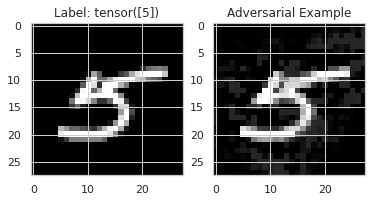

In [33]:
perturbed_image = x_adv
# Plot the original and perturbed images
fig, axs = plt.subplots(1, 2)
with torch.no_grad(): 
    axs[0].imshow(img[index].squeeze(), cmap='gray')
    axs[0].set_title(f"Label: {lab[index]}")
    axs[1].imshow(perturbed_image.squeeze(), cmap='gray')
    axs[1].set_title("Adversarial Example")
plt.show()

In [34]:
with torch.no_grad():
    test_output, last_layer = model(img[index])
    perturb_output, last_layer = model(perturbed_image)

print(f"Test :- {test_output} \nPerturb :- {perturb_output}")

Test :- tensor([[-12.9338, -12.3719,  -8.5549,   2.2139,  -8.7200,  10.1662,  -9.5347,
          -8.0836,  -1.7515,  -4.5709]]) 
Perturb :- tensor([[-12.3667, -11.2376,  -8.1449,  -3.3381,  -8.6232,  12.9385,  -9.6500,
          -6.7693,  -3.7982,  -4.9142]])


In [35]:
cer_y = []
cer_per = []
pred = []
count = 0

for i in range(itr):
     a, x = model(img[i])
     b, x = model(lbfgs_attack(model, loss_func, img[i], lab[i], eps=0.15, max_iter=10))
     a = torch.max(a, 1)[1].data.squeeze()
     b = torch.max(b, 1)[1].data.squeeze()
     if a != b:
         count += 1
     unc_a,_,_,_,_ = uncertainty(model,img[i],lab[i])
     unc_b,_,_,_,_ = uncertainty(model,lbfgs_attack(model, loss_func, img[i], lab[i], eps=0.15, max_iter=10),lab[i])
     unc_a = normalize(unc_a)
     unc_b = normalize(unc_b)
     cer_y.append(unc_a[0, int(a)])
     cer_per.append(unc_b[0, int(a)])
     pred.append(a)

print(count * 100 / itr)

5.0


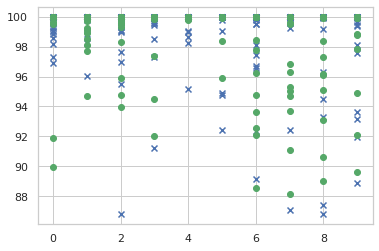

In [36]:
plt.scatter(pred, cer_y, c='b', marker='x')
plt.scatter(pred, cer_per, c='g', marker='o')

In [47]:
def distance(x,y):
  res=0
  for i in range(28):
    for j in range(28):
      res+=(x[0][0][i][j]-y[0][0][i][j])**2
  return res

In [48]:
def sen(x):
    sen_image = []
    x = x.squeeze()
    for i in range (28):
        var = []
        for j in range (28):
            n = 0
            mu = 0
            for k in range(-1,2,1):
                for z in range (-1,2,1):
                    if i+k>=28 or i+k<0 or j+z>=28 or j+z<0 :
                        continue
                    n += 1
                    mu += x[i+k][j+z]
            mu = mu/n
            s = 0
            for k in range(-1,2,1):
                for z in range (-1,2,1):
                    if i+k>=28 or i+k<0 or j+z>=28 or j+z<0 :
                        continue
                    s += (x[i+k][j+z]-mu)*(x[i+k][j+z]-mu)
            s = s/n*n
            s = math.sqrt(s)
            if s == 0: 
                s = 0.0001
            var.append(1/s)
        sen_image.append(var)
    return sen_image

In [49]:
ans = sen(img[50])

In [50]:
def gap(x,model,target,k=100):
  output,_ = model(x)
  m = nn.Softmax(dim=1)
  output = m(output)
  pt=output[0, target]
  sum = 0
  for i in range(10):
      if i != target.item() :
        sum += torch.exp(k*output[0, i])
  return pt - torch.log(sum)/k

In [51]:
def perturb_priority(x,target,sensitivity):
  perturb = []
  delta = 0.1
  #sensitivity=sen(x)
  for i in range(28):
    for j in range(28):
        with torch.no_grad():
            g_x = gap(x,model,target)
            x[0][0][i][j] += torch.tensor(delta)
            g_x_e = gap(x,model,target)
            x[0][0][i][j] -= torch.tensor(delta)
            grad = (g_x_e - g_x)/epsilon
            perturb.append(grad/sensitivity[i][j])
  return torch.tensor(perturb)

In [100]:
def our_method(img,target,model,Dmax,delta,m):
  D=0
  while D<Dmax:
    sensitivity=sen(img)
    perturb_list=perturb_priority(img,target,sensitivity)
    sorted_perturb,indices=torch.sort(perturb_list,descending=True)
    with torch.no_grad():
      for i in range(m):
        x = indices[i]/28
        y = indices[i]%28
        x = x.item()
        y = y.item()
        x = int(x)
        y = int(y)
        z = torch.zeros(img.shape)
        z[0][0][x][y] += torch.tensor(delta)
        img = torch.add(img,z)
        D += delta*sensitivity[x][y]
  return img

In [118]:
y = our_method(img[0],lab[0],model,2000,0.15,50)

In [126]:
with torch.no_grad():
    test_output, last_layer = model(img[0])
    perturb_output, last_layer = model(perturbed_image)
print(f"Test :- {test_output} \nPerturb :- {perturb_output}")

Test :- tensor([[ -7.1360,  -5.2184,  -6.2285,  -6.9734,   8.8788, -11.9075, -12.7995,
          -3.2879,  -4.3588,  -1.8443]]) 
Perturb :- tensor([[-12.1943,  -6.2902, -15.5844, -14.4789,   9.1843,  -2.7090,  -9.1136,
          -0.6736,  -3.4272,   3.7389]])


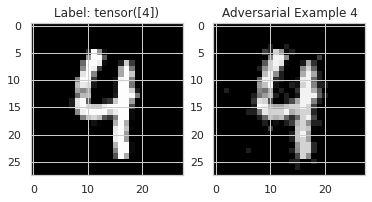

In [127]:
perturbed_image = y
perturbed_label = torch.max(perturb_output, 1)[1].data.squeeze()
# Plot the original and perturbed images
fig, axs = plt.subplots(1, 2)
with torch.no_grad(): 
    axs[0].imshow(img[0].squeeze(), cmap='gray')
    axs[0].set_title(f"Label: {lab[0]}")
    axs[1].imshow(perturbed_image.squeeze(), cmap='gray')
    axs[1].set_title(f"Adversarial Example {perturbed_label}")
plt.show()